# Sarcasm Detection using Deep Learning + NLP

In [1]:
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Loading Data and Data Analysis

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

('sarcasm.json', <http.client.HTTPMessage at 0x7d854bb9fc40>)

In [3]:
df = pd.read_json('sarcasm.json')
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [8]:
df = df[['headline', 'is_sarcastic']]
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [9]:
df.shape

(26709, 2)

In [10]:
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26709 non-null  object
 1   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.5+ KB


(None,
        is_sarcastic
 count  26709.000000
 mean       0.438953
 std        0.496269
 min        0.000000
 25%        0.000000
 50%        0.000000
 75%        1.000000
 max        1.000000)

In [11]:
df.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

In [12]:
df.duplicated().sum()

107

In [13]:
df = df.drop_duplicates()
df.duplicated().sum()

0

<Axes: xlabel='is_sarcastic', ylabel='count'>

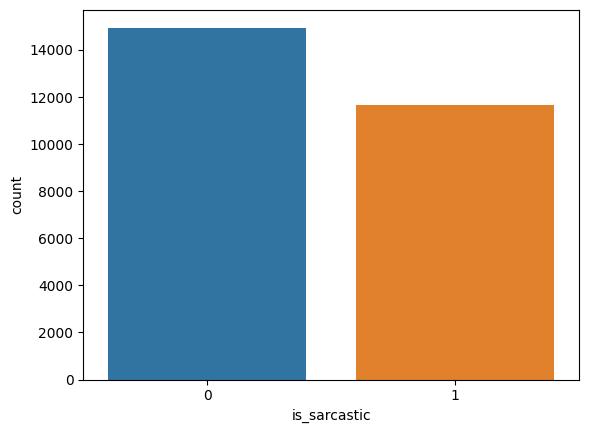

In [14]:
import seaborn as sns
sns.countplot(x='is_sarcastic', data=df)

In [15]:
X = df['headline'].to_numpy()
y = df['is_sarcastic'].to_numpy()

In [16]:
X.shape, X

((26602,),
 array(["former versace store clerk sues over secret 'black code' for minority shoppers",
        "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
        "mom starting to fear son's web series closest thing she will have to grandchild",
        ..., 'reparations and obama',
        'israeli ban targeting boycott supporters raises alarm abroad',
        'gourmet gifts for the foodie 2014'], dtype=object))

In [17]:
y, y.shape

(array([0, 0, 1, ..., 0, 0, 0]), (26602,))

## Setting up Text-Vectorization Layer

Average Tokens per Tweet is : 10 tokens
95% of our data has : 15 tokens


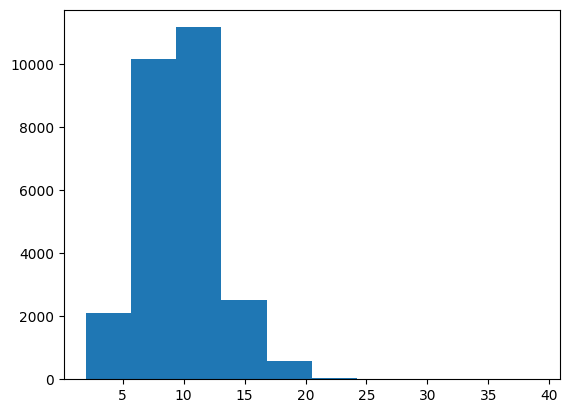

In [19]:
# find the average number of tokens per sentence
texts_length = [len(text.split()) for text in X]
plt.hist(texts_length)

np.percentile(texts_length, 95)
average_tokens_per_tweet = round(sum(texts_length)/X.shape[0])
print(f'Average Tokens per Tweet is : {average_tokens_per_tweet} tokens')
print(f'95% of our data has : {int(np.percentile(texts_length, 95))} tokens')

In [20]:
# Building Tensorflow TextVectorization Layer
from tensorflow.keras.layers import TextVectorization

max_vocab_size = 30000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_size, # how many words in the vocabulary
                                    output_sequence_length=max_length,
                                    output_mode='int')

# Fit the text_vectorizer to train_data
text_vectorizer.adapt(X)

In [21]:
print(text_vectorizer(X[24599]))

tf.Tensor(
[18652  1444   360     2    22 25820    35    57    60   217     0     0
     0     0     0], shape=(15,), dtype=int64)


In [22]:
tweets_vocab = text_vectorizer.get_vocabulary()
print(f'Words in vocabulary : {len(tweets_vocab)}')
print(f'Top 5 words : {tweets_vocab[:5]}')
print(f'Bottom 5 words : {tweets_vocab[-5:]}')

Words in vocabulary : 28435
Top 5 words : ['', '[UNK]', 'to', 'of', 'the']
Bottom 5 words : ['100000aday', '1000000', '02', '00003', '00000000001']


In [23]:
vectorized_X = text_vectorizer(X)
vectorized_X, vectorized_X.shape

(<tf.Tensor: shape=(26602, 15), dtype=int64, numpy=
 array([[  295, 15299,   800, ...,     0,     0,     0],
        [    4,  8777,  3348, ...,     9,   948,     0],
        [  140,   824,     2, ...,     2, 13018,     0],
        ...,
        [ 8846,     9,    66, ...,     0,     0,     0],
        [ 1825,   375,  3847, ...,     0,     0,     0],
        [23088,  1681,     6, ...,     0,     0,     0]])>,
 TensorShape([26602, 15]))

## Build Data Input pipelines using `tf.data.Dataset`

In [24]:
data = tf.data.Dataset.from_tensor_slices((vectorized_X, y))
data = data.shuffle(vectorized_X.shape[0]).batch(32).prefetch(tf.data.AUTOTUNE)

In [25]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 15), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Partioning our data

In [26]:
len(data)

832

In [27]:
train_size, test_size = int(len(data)*0.8), int(len(data)*0.2)
train_size, test_size

(665, 166)

In [28]:
train_data = data.take(train_size)
test_data = data.skip(train_size).take(test_size)

train_data, test_data

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 15), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 15), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Setting up callbacks

In [29]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            monitor='val_accuracy',
																						verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model Building & Experiments

In [31]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout

### Model 1

In [34]:
model1 = Sequential([
    Embedding(input_dim=len(tweets_vocab),
              output_dim=128,
              input_length=max_length),
    Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
    Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
    Bidirectional(LSTM(64, activation='relu')),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [36]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 128)           3639680   
                                                                 
 bidirectional (Bidirection  (None, 15, 256)           263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 15, 256)           394240    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                        

In [37]:
history1 = model1.fit(train_data, epochs=20, validation_data=test_data,
                      callbacks=[create_model_checkpoint(model_name='Model1')])

Epoch 1/20
665/665 [==============================] - 157s 213ms/step - loss: 0.4361 - accuracy: 0.8064 - val_loss: 0.2415 - val_accuracy: 0.9183
Epoch 2/20
665/665 [==============================] - 124s 187ms/step - loss: 0.2627 - accuracy: 0.9239 - val_loss: 0.1037 - val_accuracy: 0.9635
Epoch 3/20
665/665 [==============================] - 126s 189ms/step - loss: 0.1149 - accuracy: 0.9602 - val_loss: 0.1072 - val_accuracy: 0.9812
Epoch 4/20
665/665 [==============================] - 127s 191ms/step - loss: 0.0657 - accuracy: 0.9798 - val_loss: 0.0291 - val_accuracy: 0.9908
Epoch 5/20
665/665 [==============================] - 126s 189ms/step - loss: 0.0352 - accuracy: 0.9894 - val_loss: 0.0154 - val_accuracy: 0.9960
Epoch 6/20
665/665 [==============================] - 126s 189ms/step - loss: 0.0168 - accuracy: 0.9946 - val_loss: 0.0074 - val_accuracy: 0.9979
Epoch 7/20
665/665 [==============================] - 126s 189ms/step - loss: 0.0107 - accuracy: 0.9964 - val_loss: 0.0037 -

## Model Evaluation

In [38]:
model1.evaluate(test_data)

166/166 [==============================] - 4s 21ms/step - loss: 0.0084 - accuracy: 0.9972


[0.008362473919987679, 0.9971762299537659]

In [39]:
model1 = tf.keras.models.load_model('./model_experiments/Model1')
model1.evaluate(test_data)

166/166 [==============================] - 3s 14ms/step - loss: 0.0022 - accuracy: 0.9994


[0.002174203749746084, 0.9994352459907532]

<Axes: >

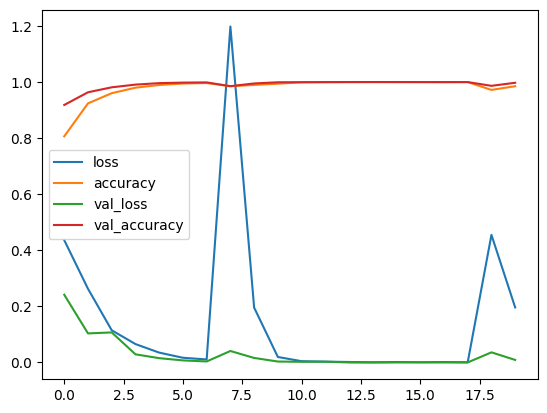

In [40]:
pd.DataFrame(history1.history).plot()

## Prediction on custom dataset

In [47]:
classes = ['Not sarcastic', 'Sarcastic Review']
def make_prediction(review):
  input_tensor = text_vectorizer([review])
  y_probs = model1.predict(input_tensor)
  y_preds = tf.round(y_probs)
  print(f'Input Sentence : \n{review}')
  print(f'Model Prediction : {classes[int(tf.squeeze(y_preds))]}')

In [49]:
make_prediction(['She tried to give a sarcastic turn to this idea.'])

1/1 [==============================] - 0s 98ms/step
Input Sentence : 
['She tried to give a sarcastic turn to this idea.']
Model Prediction : Not sarcastic


In [52]:
df.iloc[2]['headline']

"mom starting to fear son's web series closest thing she will have to grandchild"

In [53]:
df.iloc[3]['headline']

'boehner just wants wife to listen, not come up with alternative debt-reduction ideas'

In [55]:
make_prediction(["mom starting to fear son's web series closest thing she will have to grandchild"])

1/1 [==============================] - 0s 51ms/step
Input Sentence : 
["mom starting to fear son's web series closest thing she will have to grandchild"]
Model Prediction : Sarcastic Review


In [56]:
make_prediction(['boehner just wants wife to listen, not come up with alternative debt-reduction ideas'])

1/1 [==============================] - 0s 56ms/step
Input Sentence : 
['boehner just wants wife to listen, not come up with alternative debt-reduction ideas']
Model Prediction : Sarcastic Review


## Saving best model

In [58]:
model1.save('99%_acc_BI-lstm_model.h5')